In this short tutorial we will install and use [MARTINI](https://kyleaoman.github.io/martini/build/html/includeme.html), an analysis package for creating mock HI-data cubes similar to radio interferometer data, written by Kyle Oman (kyle.a.oman@durham.ac.uk).

This walkthrough will also show how you can download and install additional software into your JupyterLab environment to assist in analysis of Illustris[TNG] simulations.

![MARTINI](http://kyleaoman.github.io/martini/build/html/_images/martini_banner.png)

MARTINI is a modular package for the creation of synthetic resolved HI line observations (data cubes) of smoothed-particle hydrodynamics simulations of galaxies. The various aspects of the mock-observing process are divided logically into sub-modules handling the data cube, source, beam, noise, spectral model and SPH kernel. MARTINI is object-oriented: each sub-module provides a class (or classes) which can be configured as desired. For most sub-modules, base classes are provided to allow for straightforward customization. Instances of each sub-module class are then given as parameters to the Martini class. A mock observation is then constructed by calling a handful of functions to execute the desired steps in the mock-observing process.

## Installation

We will use `git` and `pip` to download and install [MARTINI from github](https://github.com/kyleaoman/martini). To do so:

1. open up a shell (File -> New -> Terminal, in the menubar)
2. click and drag its tab to the right, so you can see it and this notebook at the same time
2. type the following commands:

```
git clone https://github.com/kyleaoman/martini
pip install --user martini/

git clone https://github.com/kyleaoman/Hdecompose
pip install --user Hdecompose/
```

The `Hdecompose` package is a small helper to calculate the amount of atomic vs. molecular hydrogen (HI vs. H2) in a gas cell, given its total amount of neutral hydrogen. This step can use other "H2 models" in the future.

## TNG Example

First, import Martini. 

In [1]:
from martini.sources import TNGSource

If this produces errors (like above), you may need to restart the Python kernel of this notebook so that it sees the recently installed packages (Kernel -> Restart Kernel in the menubar).

In [2]:
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import GaussianKernel, CubicSplineKernel
import astropy.units as U

The parameters `myBasePath`, `mySnap` and `myId` follow the usual TNG conventions as in the `illustris_python` package. Here `myId` is the ID of the subhalo we wish to post-process.

In [3]:
myBasePath = '../sims.TNG/TNG100-1/output/'
mySnap = 99
myId = 385350  # first central with 218 < Vmax < 220, and SFR > 1

The different martini sub-modules need to be initialized, reading [this overview](https://kyleaoman.github.io/martini/build/html/martini.html) is recommended before continuing this example. 

See the [full documentation](https://kyleaoman.github.io/martini/build/html/) for the individual sub-modules for details of all configuration options. A few suggested best-practices specific to TNG are outlined below.

### SOURCE
The rotation configuration takes an inclination (here 60deg) and
rotation about the pole (here 0deg). The code attempts to
automatically align the galactic disk in the y-z plane by aligning
the angular momentum along the x-axis. The polar rotation is then
applied, and finally the disc inclined by a rotation around the
y-axis (the line of sight is along the x-axis). The automatic
alignment will work for typical reasonably isolated discs, but will
struggle when companions are present, when the angular momentum axis
is a poor tracer of the disc plane, and especially for satellites. If
finer control of the orientation is needed, derive the transformation
from the simulation box coordinates to the desired coordinates for
the 'observation', keeping in mind that the line of sight is along
the x-axis. This rotation matrix can then be passed to rotation as
{'rotmat': np.eye(3)} (here the identity rotation matrix used as an
example). A common problem in this case is deriving the inverse
transform instead of the forward transform, if unexpected results are
obtained, first try passing the transpose of the rotation matrix.
Note that initializing the source can take some time as the particle
data must be read from disk.

In [4]:
source = TNGSource(
    myBasePath,
    mySnap,
    myId,
    distance=30 * U.Mpc,
    rotation={'L_coords': (60 * U.deg, 0. * U.deg)},
    ra=0. * U.deg,
    dec=0. * U.deg
)

/home/tnguser/martini/martini/sph_kernels.py:37: UserWarning: The definition of the smoothing length has changed since earlier versions. Now all kernel modules expect the smoothing lengths provided (via the source module) to be the FWHM of the kernel. This is to avoid ambiguity in the definition. Users of simulation-specific sources (TNGSource, EAGLESource, ...) do not need to worry about this change: the sources have been updated accordingly.
  warn('The definition of the smoothing length has changed since earlier'


### DATACUBE
It is usually advisable to set the centre of the cube to track the
centre of the source, as illustrated below. Note that the source
systemic velocity is set according to the distance and Hubble's law.
These values can instead be set explicitly, if desired. A datacube
with 128x128 pixels usually takes a few minutes, 1024x1024 could take
several hours. The number of channels has less influence on the
runtime. Most of the runtime is spent when `M.insert_source_in_cube` is
called below.

In [5]:
datacube = DataCube(
    n_px_x=128,
    n_px_y=128,
    n_channels=64,
    px_size=10. * U.arcsec,
    channel_width=40. * U.km * U.s ** -1,
    velocity_centre=source.vsys,
    ra=source.ra,
    dec=source.dec
)

### BEAM
It is usually advisable to set the beam size to be ~3x the pixel
size. Note that the data cube is padded according to the size of the
beam, this usually results in the number of pixel rows printed in the
progress messages to differ from the requested dimensions. The
padding is required for accurate convolution with the beam, but
contains incorrect values after convolution and is discarded to
produce the final data cube of the requested size.

In [6]:
beam = GaussianBeam(
    bmaj=30. * U.arcsec,
    bmin=30. * U.arcsec,
    bpa=0. * U.deg,
    truncate=3.
)

### NOISE
The noise is normally added before convolution with the beam (as
below in this example). The rms value passed is for the noise before
convolution, the rms noise in the output data cube will therefore
typically differ from this value.

In [7]:
noise = GaussianNoise(
    rms=2.E-6 * U.Jy * U.arcsec ** -2
)

### SPECTRAL MODEL
The 'subgrid' velocity dispersion can also be fixed to a constant
value, e.g. `sigma=7 * U.km / U.s`.

In [8]:
spectral_model = GaussianSpectrum(
    sigma='thermal'
)

### SPH KERNEL
Since IllustrisTNG uses a moving mesh hydrodynamics solver (Arepo),
there are no formal SPH smoothing lengths and no specified kernel.
However, approximate smoothing lengths can be derived from the cell
volumes and densities, so a
reasonable approximation is to use these for imaging. The choice of kernel depends on the resolution of the observation (i.e. the size of the sph smoothing kernel of each particle relative to the pixel size). The integration of the kernels is imlpemented approximately, and the approximations hold only over some range of kernel sizes. Some general rules of thumb:
 - For very low resolution observations (distant source and few pixels), use the DiracDeltaKernel.
 - For high resolution observations (nearby source and many pixels), preferably use the kernel matching that used to run the simulation. In the case of Arepo, which uses a moving mesh rather than SPH, the CubicSplineKernel is suggested.
 - For intermediate resolution observations (when the kernel size is similar to the pixel size), it may be difficult to find a kernel which does not raise an error. In this case, you may consider using GaussianKernel(truncate=6), which is sufficiently accurate to be used with any smoothing lengths, but can slow down the calculation somewhat. This example falls into this last category.

In [9]:
sph_kernel = GaussianKernel(truncate=6)

/home/tnguser/martini/martini/sph_kernels.py:37: UserWarning: The definition of the smoothing length has changed since earlier versions. Now all kernel modules expect the smoothing lengths provided (via the source module) to be the FWHM of the kernel. This is to avoid ambiguity in the definition. Users of simulation-specific sources (TNGSource, EAGLESource, ...) do not need to worry about this change: the sources have been updated accordingly.
  warn('The definition of the smoothing length has changed since earlier'


Now set up the configuration, and do the actual run:

In [10]:
M = Martini(
    source=source,
    datacube=datacube,
    beam=beam,
    noise=noise,
    spectral_model=spectral_model,
    sph_kernel=sph_kernel
)

### Run the calculation

Progress messages will be printed every `printfreq` rows; suppress by setting to `None`.

In [11]:
M.insert_source_in_cube(printfreq=10)
M.add_noise()
M.convolve_beam()

/home/tnguser/martini/martini/sph_kernels.py:774: UserWarning: GaussianKernel with truncation >=6sigma may unnecessarily slow down computation.
  warn("GaussianKernel with truncation >=6sigma may unnecessarily "
/home/tnguser/.local/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


    [columns: 148, rows: 148]
    [row 0]
    [row 10]
    [row 20]
    [row 30]
    [row 40]
    [row 50]
    [row 60]
    [row 70]
    [row 80]
    [row 90]
    [row 100]
    [row 110]
    [row 120]
    [row 130]
    [row 140]


To write the results: two output formats are available, depending on preference. Both
formats are self-documenting, via FITS header keywords and HDF5
attributes, respectively. For HDF5 output, the beam image is included
in the same file.

In [12]:
M.write_fits('tngdemo.fits', channels='velocity')
M.write_beam_fits('tngdemo_beam.fits', channels='velocity')
M.write_hdf5('tngdemo.hdf5', channels='velocity')

### Inspect the results

Let's load the HDF5 that MARTINI produced and take a quick look.

In [13]:
import h5py
f = h5py.File('tngdemo.hdf5','r')

In [14]:
list(f.keys())

['Beam', 'Dec', 'FluxCube', 'RA', 'channel_mids']

In [15]:
FluxCube = f['FluxCube'][()]
vch = f['channel_mids'][()] / 1E3 - source.distance.to(U.Mpc).value*70  # m/s to km/s
f.close()

In [16]:
FluxCube.shape

(128, 128, 64)

Let's examine one of the velocity channels:

In [17]:
import matplotlib.pyplot as plt

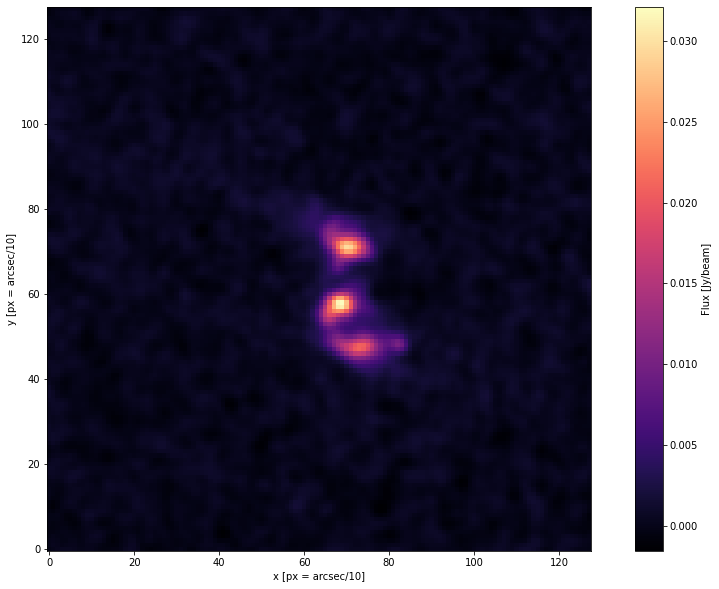

In [23]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

plt.imshow(FluxCube[:,:,32].T, cmap='magma', aspect=1.0, origin='lower')
ax.autoscale(False)
ax.set_xlabel('x [px = arcsec/10]')
ax.set_ylabel('y [px = arcsec/10]')
plt.colorbar(label='Flux [Jy/beam]');

And do a quick plot of the first three moments:

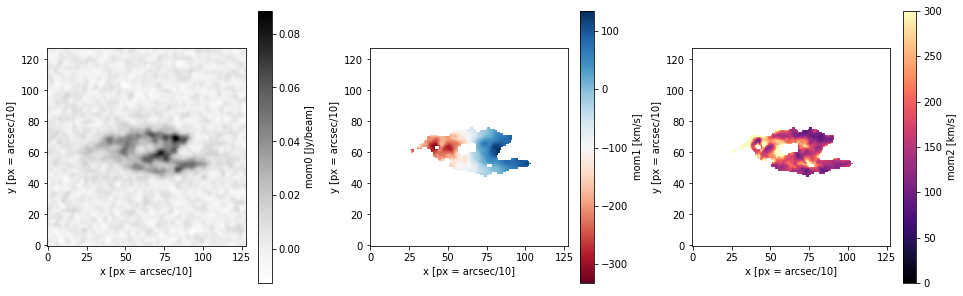

In [29]:
import numpy as np
np.seterr(all='ignore')
fig = plt.figure(figsize=(16, 5))
sp1 = fig.add_subplot(1,3,1)
sp2 = fig.add_subplot(1,3,2)
sp3 = fig.add_subplot(1,3,3)
rms = np.std(FluxCube[:16, :16])  # noise in a corner patch where there is little signal
clip = np.where(FluxCube > 5 * rms, 1, 0)
mom0 = np.sum(FluxCube, axis=-1)
mask = np.where(mom0 > .02, 1, np.nan)
mom1 = np.sum(FluxCube * clip * vch, axis=-1) / mom0
mom2 = np.sqrt(np.sum(FluxCube * clip * np.power(vch - mom1[..., np.newaxis], 2), axis=-1)) / mom0
im1 = sp1.imshow(mom0.T, cmap='Greys', aspect=1.0, origin='lower')
plt.colorbar(im1, ax=sp1, label='mom0 [Jy/beam]')
im2 = sp2.imshow((mom1*mask).T, cmap='RdBu', aspect=1.0, origin='lower')
plt.colorbar(im2, ax=sp2, label='mom1 [km/s]')
im3 = sp3.imshow((mom2*mask).T, cmap='magma', aspect=1.0, origin='lower', vmin=0, vmax=300)
plt.colorbar(im3, ax=sp3, label='mom2 [km/s]')
for sp in sp1, sp2, sp3:
    sp.set_xlabel('x [px = arcsec/10]')
    sp.set_ylabel('y [px = arcsec/10]')
plt.subplots_adjust(wspace=.3)

Though it is clearly rotating, the disc of this particular galaxy seems somewhat disturbed, with a possible tail or hole on the right edge, and a central hole. The velocity dispersion is also surprisingly high (beam smearing will contribute to this somewhat, but is insufficient to fully explain it).

For complete documentation, more usage examples, and further information, please take a look at the [MARTINI webpage](https://kyleaoman.github.io/martini).